# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Indest Data

In [6]:
df= pd.read_csv("Frozen_Dessert_Production.csv", index_col='DATE', parse_dates=True)

## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [7]:
df

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [9]:
df.columns = ['Production']

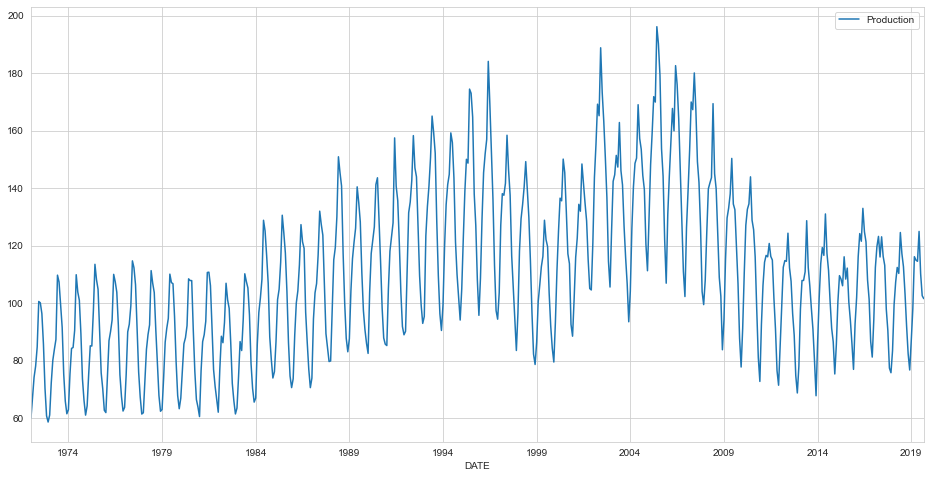

In [11]:
df.plot(figsize=(16,8));

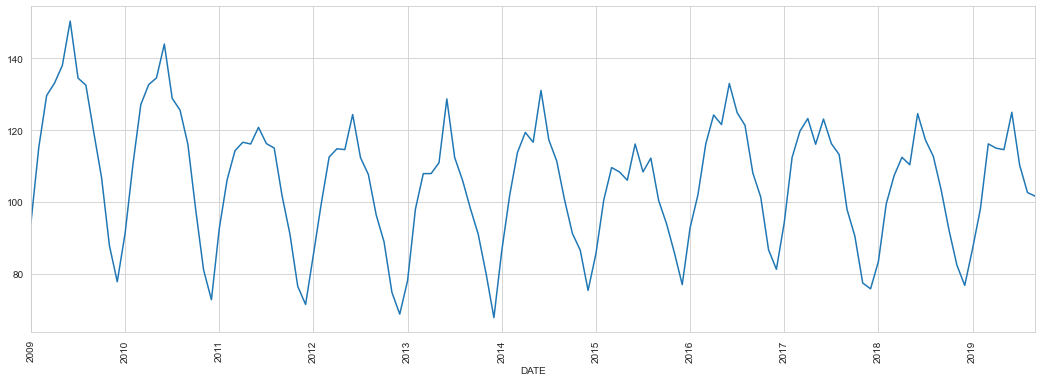

In [53]:
df['Production'].loc["2009-01-01 00:00:00" : ].plot(figsize=(18,6))
plt.xticks(rotation=90);

## Preprocessing of Data

### Train Test Split

In [14]:
test_size = 24
test_ind = len(df)- test_size
test_ind

549

In [15]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [16]:
train

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2017-05-01,116.064
2017-06-01,123.087
2017-07-01,116.264


In [17]:
test

,Production
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


### Scaling

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()

In [20]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [23]:
len(generator)

537

In [24]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

In [25]:
X, y = generator[0]

In [26]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Creating Model

### with "tanh" activation function

In [31]:
n_features = train_scaled.shape[1]
n_features

1

In [98]:
model = Sequential()
model.add(LSTM(50, activation = 'tanh',  input_shape = (length, n_features)))
##model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [93]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 50)                10400     
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [37]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)
len(validation_generator)

12

In [99]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 5s 6ms/step - loss: 0.0258 - val_loss: 0.0052
Epoch 2/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0069 - val_loss: 0.0020
Epoch 3/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 4/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 5/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 6/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 7/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 8/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 9/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 10/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0029 - val_loss: 0.0019

<AxesSubplot:>

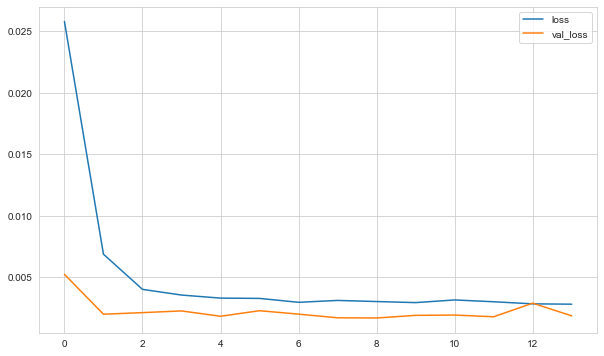

In [100]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [71]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [101]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [102]:
predictions_scaled

[array([0.24137127], dtype=float32),
 array([0.21552315], dtype=float32),
 array([0.23689274], dtype=float32),
 array([0.29224855], dtype=float32),
 array([0.3552671], dtype=float32),
 array([0.4094184], dtype=float32),
 array([0.44961366], dtype=float32),
 array([0.4704049], dtype=float32),
 array([0.47063634], dtype=float32),
 array([0.43819407], dtype=float32),
 array([0.38058725], dtype=float32),
 array([0.30861908], dtype=float32)]

In [103]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.6593717055453314 
mae: 0.05247392553091198 
mse: 0.004247852423034867 
rmse: 0.06517555080729942


#### Inverse Transformations and Comparing

In [104]:
predictions = scaler.inverse_transform(predictions_scaled)

In [105]:
compare = test[:12]

In [106]:
compare['Predictions'] = predictions

In [107]:
compare

,Production,Predictions
DATE,,
2017-10-01,90.473,91.852
2017-11-01,77.438,88.297
2017-12-01,75.812,91.236
2018-01-01,83.434,98.848
2018-02-01,99.490,107.514
2018-03-01,107.315,114.961
2018-04-01,112.431,120.488
2018-05-01,110.354,123.347
2018-06-01,124.584,123.379


<AxesSubplot:xlabel='DATE'>

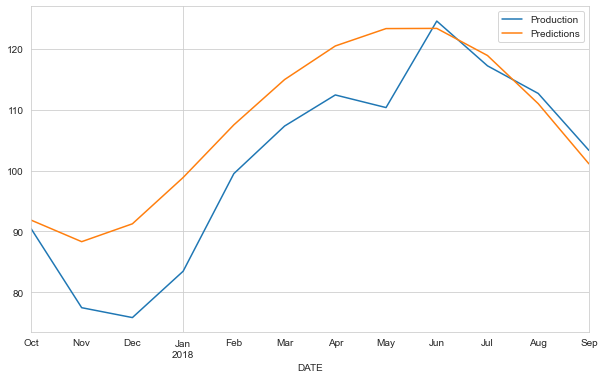

In [108]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [109]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.6593717055453321 
mae: 7.21589414806527 
mse: 80.32719810961747 
rmse: 8.962544176159884


### with "relu" activation function

In [130]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [131]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 6s 8ms/step - loss: 0.0253 - val_loss: 0.0034
Epoch 2/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0081 - val_loss: 0.0040
Epoch 3/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0071 - val_loss: 0.0120
Epoch 4/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0076 - val_loss: 0.0053
Epoch 5/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0060 - val_loss: 0.0028
Epoch 6/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 7/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 8/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 9/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 10/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0047 - val_loss: 0.0020

<AxesSubplot:>

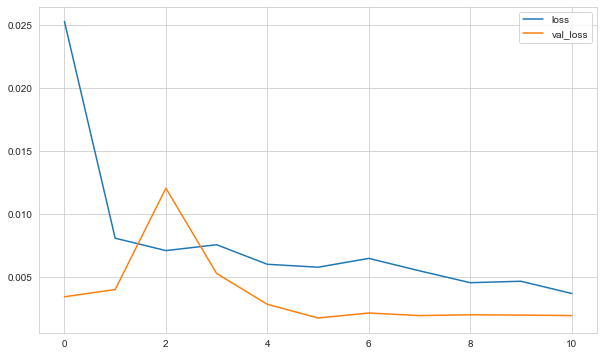

In [132]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [133]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [134]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.4586528310881781 
mae: 0.07235902776756951 
mse: 0.006750945005454262 
rmse: 0.08216413454454603


#### Inverse Transformations and Comparing

In [135]:
predictions = scaler.inverse_transform(predictions_scaled)

In [136]:
compare = test[:12]

In [137]:
compare['Predictions'] = predictions

In [138]:
compare

,Production,Predictions
DATE,,
2017-10-01,90.473,97.549
2017-11-01,77.438,89.107
2017-12-01,75.812,88.896
2018-01-01,83.434,100.394
2018-02-01,99.490,112.232
2018-03-01,107.315,120.995
2018-04-01,112.431,125.329
2018-05-01,110.354,127.944
2018-06-01,124.584,128.390


<AxesSubplot:xlabel='DATE'>

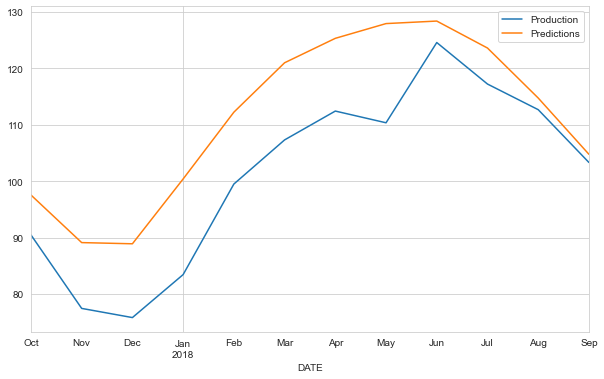

In [139]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [141]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.45865283108817867 
mae: 9.95037210852677 
mse: 127.66086080100298 
rmse: 11.298710581345244


## Bonus : Using only the latest time data

In [145]:
df['Production'].loc["2011-01-01 00:00:00" :]

DATE
2011-01-01    92.611
2011-02-01   106.166
2011-03-01   114.248
2011-04-01   116.623
2011-05-01   116.136
               ...  
2019-05-01   114.561
2019-06-01   124.960
2019-07-01   110.263
2019-08-01   102.609
2019-09-01   101.587
Name: Production, Length: 105, dtype: float64

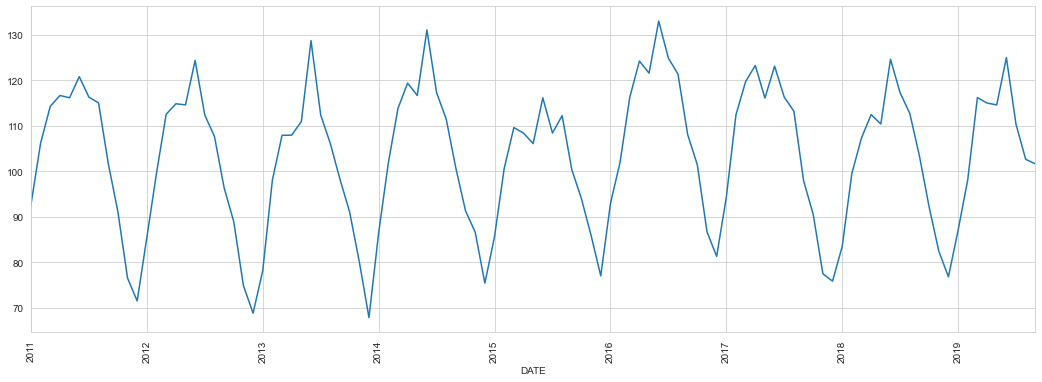

In [146]:
df['Production'].loc["2011-01-01 00:00:00" :].plot(figsize=(18,6))
plt.xticks(rotation=90);

In [147]:
df_latest = df['Production'].loc["2011-01-01 00:00:00" :]

In [152]:
len(df_latest)

105

In [153]:
test_size = 24

In [154]:
test_ind = len(df_latest)- test_size
test_ind

81

In [155]:
train_latest = df.iloc[:test_ind]
test_latest = df.iloc[test_ind:]

In [156]:
train_scaled_latest = scaler.fit_transform(train_latest)
test_scaled_latest = scaler.transform(test_latest)

In [157]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled_latest, train_scaled_latest, length = length, batch_size = batch_size)

In [158]:
len(generator)

69

In [159]:
X, y = generator[0]

In [177]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [165]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [178]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
69/69 [==============================] - 3s 13ms/step - loss: 0.1075 - val_loss: 0.0139
Epoch 2/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0604 - val_loss: 0.0401
Epoch 3/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0133 - val_loss: 0.0262
Epoch 4/20
69/69 [==============================] - 0s 7ms/step - loss: 0.0132 - val_loss: 0.0359
Epoch 5/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0237
Epoch 6/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0061
Epoch 7/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0159
Epoch 8/20
69/69 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0155
Epoch 9/20
69/69 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 10/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 11/20
69/69 

<AxesSubplot:>

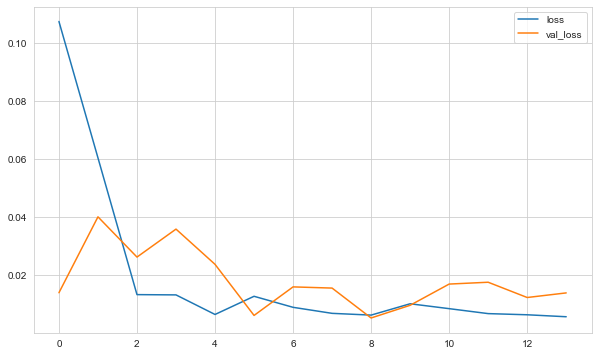

In [179]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [180]:
predictions_scaled_latest = []

first_eval_batch = train_scaled_latest[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled_latest.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [181]:
eval_metrics(test_scaled[:length], predictions_scaled_latest)

r2_score: -4.39928325150173 
mae: 0.20132308757249207 
mse: 0.06733251117398142 
rmse: 0.25948508853878566


never mind !!!

In [182]:
predictions = scaler.inverse_transform(predictions_scaled_latest)
compare = test[:12]
compare['Predictions'] = predictions
compare

,Production,Predictions
DATE,,
2017-10-01,90.473,76.064
2017-11-01,77.438,65.558
2017-12-01,75.812,61.254
2018-01-01,83.434,64.025
2018-02-01,99.490,71.731
2018-03-01,107.315,80.470
2018-04-01,112.431,89.210
2018-05-01,110.354,98.218
2018-06-01,124.584,106.911


<AxesSubplot:xlabel='DATE'>

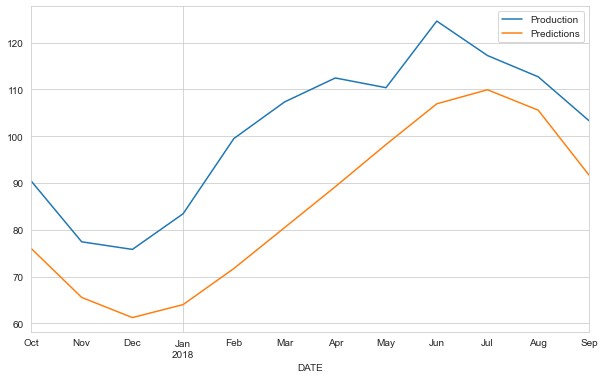

In [183]:
compare.plot()

In [185]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: -0.29566241342167054 
mae: 16.161643688386434 
mse: 305.54399931083395 
rmse: 17.479816912966623


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [186]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [187]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [188]:
len(df)

573

In [189]:
len(generator)

561

In [190]:
model = Sequential()
model.add(LSTM(50, activation = 'tanh',  input_shape = (length, n_features)))
##model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [192]:
model.fit_generator(generator, epochs=15)

Epoch 1/15
561/561 [==============================] - 4s 5ms/step - loss: 0.0217
Epoch 2/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0061
Epoch 3/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0042
Epoch 4/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0040
Epoch 5/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0033
Epoch 6/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0032
Epoch 7/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0033
Epoch 8/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0032
Epoch 9/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0032
Epoch 10/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0029
Epoch 11/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0030
Epoch 12/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0030
Epoch 13/15
561/561 [====

In [191]:
scaled_full_data.shape

(573, 1)

In [193]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [194]:
forecast = scaler.inverse_transform(forecast)

In [195]:
forecast

array([[70.83952126],
       [67.64032932],
       [66.86860894],
       [68.79878874],
       [72.06024939],
       [75.50619209],
       [78.2061466 ],
       [80.26770832],
       [81.39688589],
       [80.70127942],
       [78.78645524],
       [75.74349774]])

In [196]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [197]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')

In [198]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

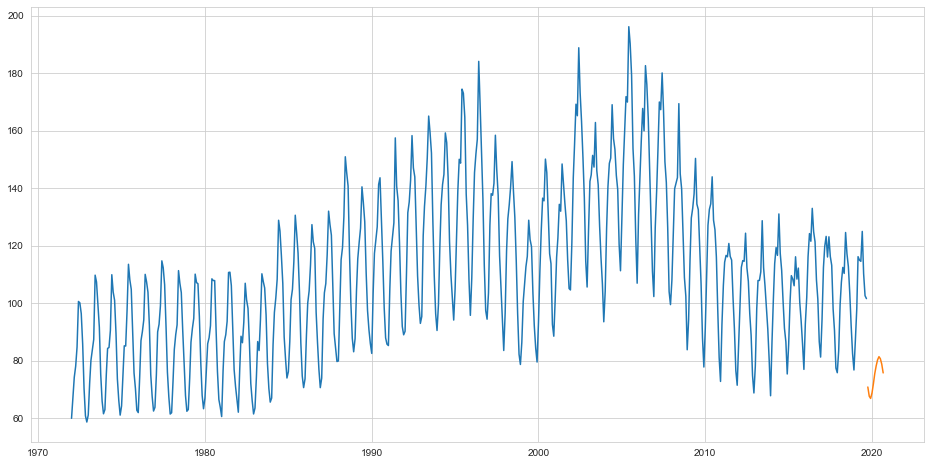

In [200]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Production'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

(576.0, 611.0)

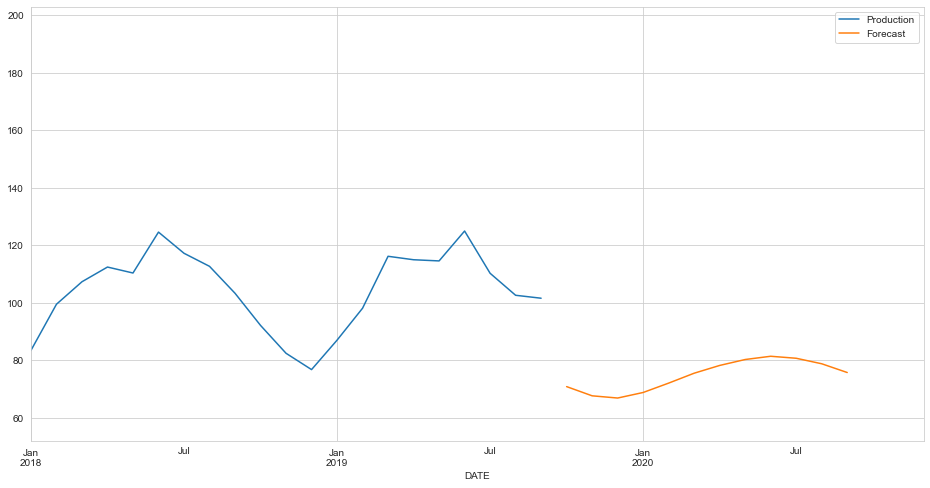

In [201]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')

:face_with_head_bandage: